In [1]:
import os, math, random, argparse, itertools
from pathlib import Path
from collections import defaultdict
from typing import List, Tuple

import numpy as np
from PIL import Image, ImageFile
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from torchvision.transforms.functional import InterpolationMode
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)

# Your Kaggle dataset root (class folders like "bench press", "deadlift", "squat")
SOURCE = Path("Dataset")

# Classes (as they appear in SOURCE) and normalized labels for reporting/UI
CLASSES_RAW = ["bench press", "deadlift", "squat"]
CLASSES = ["bench_press", "deadlift", "squat"] 

# Training / preprocessing knobs
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 20
BASE_LR = 3e-4
WEIGHT_DECAY = 1e-4
PATIENCE = 5
LABEL_SMOOTHING = 0.1
USE_MIXUP = True
MIXUP_ALPHA = 0.4
MODEL_NAME = "resnet18"   # choices: 'resnet18', 'efficientnet_b0', 'vgg16', 'alexnet', 'lenet'
OUT_WEIGHTS = "sbd_best.pt"

# Demo / deployment toggles (optional)
EXPORT_ONNX = ""          # e.g., "sbd.onnx" to export ONNX; "" to skip
LAUNCH_GRADIO = False     # True to launch a quick demo UI after training
ImageFile.LOAD_TRUNCATED_IMAGES = True

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# ============================================================
# 1) PREPROCESSING — transforms
# ============================================================
train_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE), interpolation=InterpolationMode.BICUBIC),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomApply([transforms.ColorJitter(0.2,0.2,0.2,0.05)], p=0.5),
    transforms.RandomRotation(10, interpolation=InterpolationMode.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])
eval_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE), interpolation=InterpolationMode.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])

In [4]:
# ============================================================
# 2) DATA ANNOTATION / INGEST (OPTIONAL)
#    - If you add your own images (curation/annotation), copy them in.
# ============================================================
def list_images(dir_path: Path) -> List[Path]:
    exts = (".jpg",".jpeg",".png",".webp",".bmp")
    return [dir_path/f for f in os.listdir(dir_path) if f.lower().endswith(exts)]

def ingest_own_data(own_root: Path, source_root: Path):
    """Copy your own annotated images into the SOURCE class folders.
       Expected own_root has subfolders: bench_press, deadlift, squat."""
    mapping = {
        "bench_press": "bench press",
        "deadlift": "deadlift",
        "squat": "squat",
    }
    for norm, raw in mapping.items():
        src = own_root/norm
        dst = source_root/raw
        if not src.exists(): 
            print(f"[ingest] Skip: {src} not found")
            continue
        dst.mkdir(parents=True, exist_ok=True)
        imgs = list_images(src)
        for p in imgs:
            shutil.copy2(p, dst / p.name)
        print(f"[ingest] Copied {len(imgs)} from {src} -> {dst}")
    print("[ingest] Done.")



In [5]:
# ============================================================
# 3) DATASET SPLIT — random, stratified, non-overlapping (Option B)
#     No folder rewriting; we split indices in memory per class.
# ============================================================
def stratified_split(paths: List[Path], labels: List[int], splits=(0.70,0.15,0.15), seed=SEED):
    random.seed(seed)
    by_class = defaultdict(list)
    for p, y in zip(paths, labels): by_class[y].append(p)
    for k in by_class: random.shuffle(by_class[k])

    train_p, val_p, test_p = [], [], []
    train_y, val_y, test_y = [], [], []
    for y, arr in by_class.items():
        n = len(arr); n_train = int(n*splits[0]); n_val = int(n*splits[1])
        t, v, te = arr[:n_train], arr[n_train:n_train+n_val], arr[n_train+n_val:]
        train_p += t; val_p += v; test_p += te
        train_y += [y]*len(t); val_y += [y]*len(v); test_y += [y]*len(te)
    return (train_p, train_y), (val_p, val_y), (test_p, test_y)

def gather_paths_and_labels(source: Path):
    class_to_idx = {name:i for i,name in enumerate(CLASSES_RAW)}
    all_paths, all_labels = [], []
    for raw_name in CLASSES_RAW:
        folder = source/raw_name
        assert folder.exists(), f"Missing folder: {folder}"
        files = list_images(folder)
        all_paths += files
        all_labels += [class_to_idx[raw_name]]*len(files)
    return all_paths, all_labels

class SimpleImageDataset(Dataset):
    def __init__(self, paths: List[Path], labels: List[int], tfm):
        self.paths = paths; self.labels = labels; self.tfm = tfm
    def __len__(self): return len(self.paths)
    def __getitem__(self, i):
        img = Image.open(self.paths[i]).convert("RGB")
        return self.tfm(img), self.labels[i]

def count_per_class(labels: List[int]):
    from collections import Counter
    c = Counter(labels)
    return {CLASSES[i]: c.get(i,0) for i in range(len(CLASSES))}


In [6]:
# ============================================================
# 4) MODEL — baseline → modern CNNs
# ============================================================
class LeNet5(nn.Module):
    def __init__(self, num_classes=3):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 6, 5, padding=2), nn.Sigmoid(), nn.AvgPool2d(2),
            nn.Conv2d(6,16,5),             nn.Sigmoid(), nn.AvgPool2d(2),
            nn.Flatten(),
            nn.Linear(16*53*53,120), nn.Sigmoid(),
            nn.Linear(120,84),       nn.Sigmoid(),
            nn.Linear(84, num_classes)
        )
    def forward(self,x): return self.net(x)

def build_model(name: str, num_classes: int):
    n = name.lower()
    if n == "lenet":
        return LeNet5(num_classes)
    if n == "alexnet":
        m = models.alexnet(weights=models.AlexNet_Weights.IMAGENET1K_V1)
        m.classifier[6] = nn.Linear(m.classifier[6].in_features, num_classes); return m
    if n == "vgg16":
        m = models.vgg16_bn(weights=models.VGG16_BN_Weights.IMAGENET1K_V1)
        m.classifier[6] = nn.Linear(m.classifier[6].in_features, num_classes); return m
    if n == "resnet18":
        m = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        m.fc = nn.Linear(m.fc.in_features, num_classes); return m
    if n == "efficientnet_b0":
        m = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)
        m.classifier[1] = nn.Linear(m.classifier[1].in_features, num_classes); return m
    raise ValueError("Unknown model name")

In [7]:
# ============================================================
# 5) TRAINING — label smoothing, mixup, cosine LR (warmup), early stopping
# ============================================================
def mixup_data(x, y, alpha=0.4):
    if alpha <= 0: return x, (y,y), 1.0
    lam = np.random.beta(alpha, alpha)
    idx = torch.randperm(x.size(0), device=x.device)
    return lam*x + (1-lam)*x[idx], (y, y[idx]), lam

def mixup_criterion(criterion, pred, targets, lam):
    y_a, y_b = targets
    return lam*criterion(pred, y_a) + (1-lam)*criterion(pred, y_b)

@torch.no_grad()
def evaluate(model, loader, criterion, device, split="Val"):
    model.eval()
    total, correct, total_loss = 0, 0, 0.0
    all_preds, all_labels = [], []
    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)
        with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
            logits = model(imgs); loss = criterion(logits, labels)
        total_loss += loss.item()*imgs.size(0)
        preds = logits.argmax(1)
        correct += (preds==labels).sum().item()
        total += labels.numel()
        all_preds += preds.cpu().tolist(); all_labels += labels.cpu().tolist()
    acc = correct / max(1,total)
    print(f"[{split}] loss={total_loss/max(1,total):.4f} acc={acc:.4f}")
    return acc, all_labels, all_preds

In [8]:
# ============================================================
# 6) EVALUATION — report + confusion matrix
# ============================================================
def plot_confusion(y_true, y_pred, filename="confusion_matrix_test.png"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    plt.imshow(cm, interpolation='nearest')
    plt.title("Confusion Matrix (Test)"); plt.colorbar()
    ticks = np.arange(len(CLASSES)); plt.xticks(ticks, CLASSES, rotation=45); plt.yticks(ticks, CLASSES)
    thr = cm.max()/2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, str(cm[i,j]), ha="center", va="center",
                     color="white" if cm[i,j] > thr else "black")
    plt.tight_layout(); plt.ylabel("True"); plt.xlabel("Predicted")
    plt.savefig(filename, dpi=200)
    print(f"Saved {filename}")

Device: cuda
SOURCE: C:\Users\zihin\OneDrive\Desktop\Year 2\Tri 1\AA1 3001 Computer Vision and Deep Learn\AAI3001ComputerVision\Dataset
Split sizes: {'train': 1327, 'val': 283, 'test': 287}
Per-class counts:
  train: {'bench_press': 437, 'deadlift': 371, 'squat': 519}
  val  : {'bench_press': 93, 'deadlift': 79, 'squat': 111}
  test : {'bench_press': 95, 'deadlift': 80, 'squat': 112}


C:\Users\zihin\AppData\Local\Temp\ipykernel_34196\1231966991.py:46: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())
C:\Users\zihin\AppData\Local\Temp\ipykernel_34196\1231966991.py:56: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


Epoch 1 train_loss=0.6069


C:\Users\zihin\AppData\Local\Temp\ipykernel_34196\2923977339.py:21: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


[Val] loss=0.3345 acc=1.0000
  ✓ Saved sbd_best.pt (val_acc=1.0000)
Epoch 2 train_loss=0.5330
[Val] loss=0.3381 acc=1.0000
Epoch 3 train_loss=0.5408
[Val] loss=0.3456 acc=0.9929
Epoch 4 train_loss=0.5045
[Val] loss=0.3335 acc=0.9965
Epoch 5 train_loss=0.4851
[Val] loss=0.3224 acc=1.0000
Epoch 6 train_loss=0.5297
[Val] loss=0.3239 acc=0.9929
  Early stopping.


C:\Users\zihin\AppData\Local\Temp\ipykernel_34196\1231966991.py:83: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(OUT_WEIGHTS, map_location=DEVICE)


[Test] loss=0.3379 acc=0.9930

Classification report (Test):
              precision    recall  f1-score   support

 bench_press     1.0000    0.9789    0.9894        95
    deadlift     0.9756    1.0000    0.9877        80
       squat     1.0000    1.0000    1.0000       112

    accuracy                         0.9930       287
   macro avg     0.9919    0.9930    0.9923       287
weighted avg     0.9932    0.9930    0.9930       287

Saved confusion_matrix_test.png


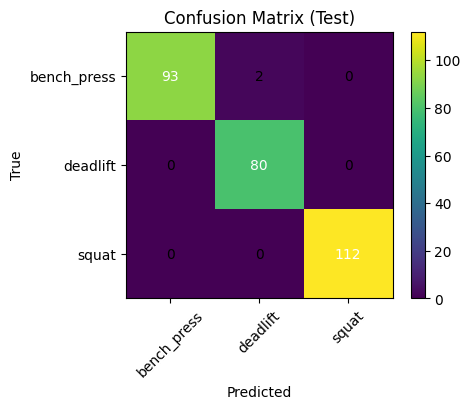

In [11]:
# ============================================================
# MAIN — runs the flow in order
# ============================================================
if __name__ == "__main__":
    print("Device:", DEVICE)
    print("SOURCE:", SOURCE.resolve())

    # Gather all labeled images (only these 3 classes)
    all_paths, all_labels = gather_paths_and_labels(SOURCE)

    # Split (stratified, reproducible, NO overlap)
    (train_p, train_y), (val_p, val_y), (test_p, test_y) = stratified_split(all_paths, all_labels, (0.70,0.15,0.15))
    # Sanity checks
    def ids(xs): return set(map(lambda p: p.resolve(), xs))
    assert ids(train_p).isdisjoint(ids(val_p)) and ids(train_p).isdisjoint(ids(test_p)) and ids(val_p).isdisjoint(ids(test_p)), \
        "Split overlap detected!"

    print("Split sizes:", {"train": len(train_p), "val": len(val_p), "test": len(test_p)})
    print("Per-class counts:")
    print("  train:", count_per_class(train_y))
    print("  val  :", count_per_class(val_y))
    print("  test :", count_per_class(test_y))

    # Build datasets/loaders
    NUM_WORKERS = 0 
    PIN_MEMORY = False
    train_ds = SimpleImageDataset(train_p, train_y, train_tfms)
    val_ds   = SimpleImageDataset(val_p,   val_y,   eval_tfms)
    test_ds  = SimpleImageDataset(test_p,  test_y,  eval_tfms)
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=NUM_WORKERS)
    val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
    test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

    # Build model & training objects
    model = build_model(MODEL_NAME, num_classes=3).to(DEVICE)
    criterion = nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTHING)
    optimizer = optim.AdamW(model.parameters(), lr=BASE_LR, weight_decay=WEIGHT_DECAY)
    # cosine LR + 2-epoch warmup
    warmup_epochs = 2
    def lr_lambda(epoch):
        if epoch < warmup_epochs:
            return (epoch + 1) / warmup_epochs
        prog = (epoch - warmup_epochs) / max(1, (EPOCHS - warmup_epochs))
        return 0.1 + 0.9 * 0.5 * (1 + math.cos(math.pi * prog))
    scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)
    scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())

    # Train with early stopping on Val Acc
    best_val, bad = -1, 0
    for epoch in range(1, EPOCHS+1):
        model.train()
        running = 0.0
        for imgs, labels in train_loader:
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad(set_to_none=True)
            with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
                if USE_MIXUP and MIXUP_ALPHA > 0:
                    imgs, targets, lam = mixup_data(imgs, labels, MIXUP_ALPHA)
                    logits = model(imgs)
                    loss = mixup_criterion(criterion, logits, targets, lam)
                else:
                    logits = model(imgs)
                    loss = criterion(logits, labels)
            scaler.scale(loss).backward()
            scaler.step(optimizer); scaler.update()
            running += loss.item()*imgs.size(0)

        scheduler.step()
        print(f"Epoch {epoch} train_loss={running/len(train_loader.dataset):.4f}")

        val_acc, y_true, y_pred = evaluate(model, val_loader, criterion, DEVICE, "Val")
        if val_acc > best_val:
            best_val, bad = val_acc, 0
            torch.save({"model": model.state_dict(), "classes": CLASSES}, OUT_WEIGHTS)
            print(f"  ✓ Saved {OUT_WEIGHTS} (val_acc={best_val:.4f})")
        else:
            bad += 1
            if bad >= PATIENCE:
                print("  Early stopping.")
                break

    # Final test
    ckpt = torch.load(OUT_WEIGHTS, map_location=DEVICE)
    model.load_state_dict(ckpt["model"]); model.eval()
    test_acc, y_true, y_pred = evaluate(model, test_loader, criterion, DEVICE, "Test")

    print("\nClassification report (Test):")
    print(classification_report(y_true, y_pred, target_names=CLASSES, digits=4))
    plot_confusion(y_true, y_pred, "confusion_matrix_test.png")